In [37]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd
from skgstat import models
import gstatsim as gsm

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time

import preprocessing
import block_update
import bouguer
import diagnostics
import rfgen
import utilities
import postprocessing

import importlib
importlib.reload(preprocessing)
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(diagnostics)
importlib.reload(rfgen)
importlib.reload(utilities)
importlib.reload(postprocessing)

from preprocessing import *
from block_update import *
from bouguer import *
from diagnostics import *
from rfgen import *
from utilities import *
from postprocessing import *

In [3]:
bm_path = Path('G:/stochastic_bathymetry/raw_data/bedmachine/BedMachineAntarctica-v3.nc')
antgg_path = Path('D:/AntGG2021_allfiles/AntGG2021_Gravity_disturbance_at-surface.nc')

# MOA: https://nsidc.org/data/nsidc-0730/versions/1
moa_base = Path('G:/stochastic_bathymetry/raw_data/nsidc0730_MEASURES_MOA2014_v01')

# moa coast and grounding line
moa_coast = gpd.read_file(moa_base/'coastlines/moa2014_coastline_v01.shp')
moa_gl = gpd.read_file(moa_base/'coastlines/moa2014_grounding_line_v01.shp')
moa_island = gpd.read_file(moa_base/'coastlines/moa2014_islands_v01.shp')

glkm = moa_gl.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
coastkm = moa_coast.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
islandkm = moa_island.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

In [4]:
ds = xr.load_dataset(Path('processed_data/salz.nc'))
ds

<xarray.Dataset> Size: 362kB
Dimensions:       (y: 60, x: 94)
Coordinates:
  * x             (x) float64 752B -1.048e+06 -1.042e+06 ... -5.825e+05
  * y             (y) float64 480B -1.378e+06 -1.372e+06 ... -1.082e+06
Data variables:
    bed           (y, x) float32 23kB -3.706e+03 -3.689e+03 ... -648.9 -567.0
    surface       (y, x) float32 23kB -55.0 -55.0 -55.0 ... 431.2 370.4 344.1
    thickness     (y, x) float32 23kB 0.0 0.0 0.0 0.0 ... 892.5 1.019e+03 911.1
    mask          (y, x) float64 45kB 0.0 0.0 0.0 0.0 0.0 ... 2.0 2.0 2.0 2.0
    geoid         (y, x) float64 45kB -55.0 -55.0 -55.0 ... -52.0 -52.0 -52.0
    source        (y, x) float64 45kB 1.0 1.0 1.0 1.0 1.0 ... 5.0 2.0 2.0 5.0
    dataid        (y, x) float64 45kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    errbed        (y, x) float32 23kB 10.0 10.0 nan 10.0 ... 142.0 141.0 32.0
    grav_surface  (y, x) float64 45kB -83.72 -89.04 -92.15 ... -43.66 -35.63
    grav_1500     (y, x) float64 45kB -79.81 -84.64 -87.34 ... -42.08 -34.78

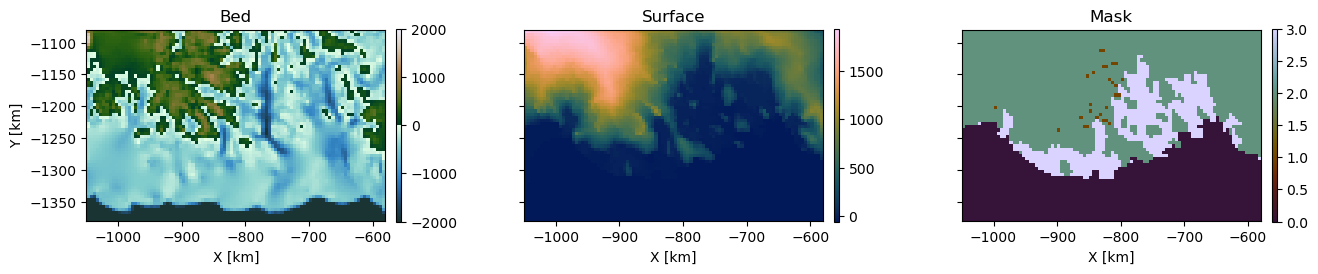

In [5]:
bedmachine_plots(ds, figsize=(16,2.5))

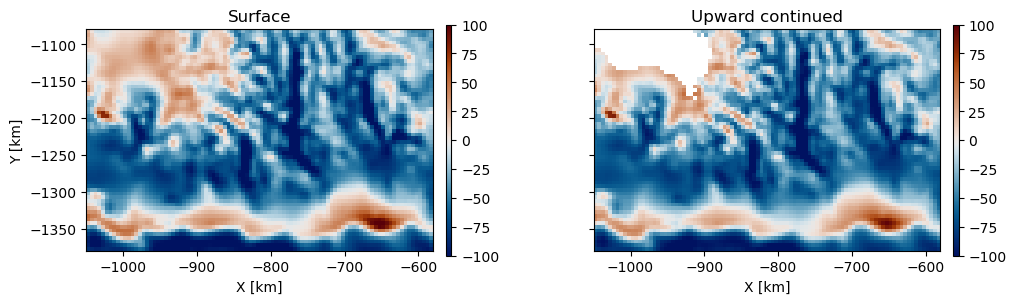

In [6]:
plot_gravity(ds, ds.grav_surface.values, ds.grav_1500.values, 1500, (12,3), 100)

In [7]:
xx, yy = np.meshgrid(ds.x.values, ds.y.values)
grav_mask = ds.surface.values < 1500
x_grav = xx[grav_mask]
y_grav = yy[grav_mask]
gdist = ds.grav_1500.values[grav_mask]

inv_msk = np.where(ds.mask==3, True, False)
inv_pad = vd.distance_mask((xx[inv_msk==True], yy[inv_msk]), 20e3, (xx, yy))

ds['inv_msk'] = (('y', 'x'), inv_msk)
ds['inv_pad'] = (('y', 'x'), inv_pad)

grav = pd.DataFrame({
    'x' : x_grav,
    'y' : y_grav,
    'height' : np.full(x_grav.size, 1500),
    'faa' : gdist,
    'inv_msk' : ds.inv_msk.values[grav_mask],
    'inv_pad' : ds.inv_pad.values[grav_mask]
})
grav

,x,y,height,faa,inv_msk,inv_pad
0,-1047500.0,-1377500.0,1500,-79.809436,False,False
1,-1042500.0,-1377500.0,1500,-84.640596,False,False
2,-1037500.0,-1377500.0,1500,-87.342873,False,False
3,-1032500.0,-1377500.0,1500,-86.684147,False,False
4,-1027500.0,-1377500.0,1500,-83.954082,False,False
...,...,...,...,...,...,...
5290,-602500.0,-1082500.0,1500,-45.472456,False,False
5291,-597500.0,-1082500.0,1500,-45.757294,False,False
5292,-592500.0,-1082500.0,1500,-46.879645,False,False
5293,-587500.0,-1082500.0,1500,-42.081284,False,False


In [8]:
ds = ds.assign_attrs(res=5000)

In [9]:
%%time

g_z = bm_terrain_effect(ds, grav)

CPU times: total: 22.9 s
Wall time: 2.52 s


In [10]:
g_z_grid = xy_into_grid(ds, (x_grav, y_grav), g_z)
gdist_masked = np.where(grav_mask, ds.grav_1500.values, np.nan)
boug_grid = gdist_masked-g_z_grid

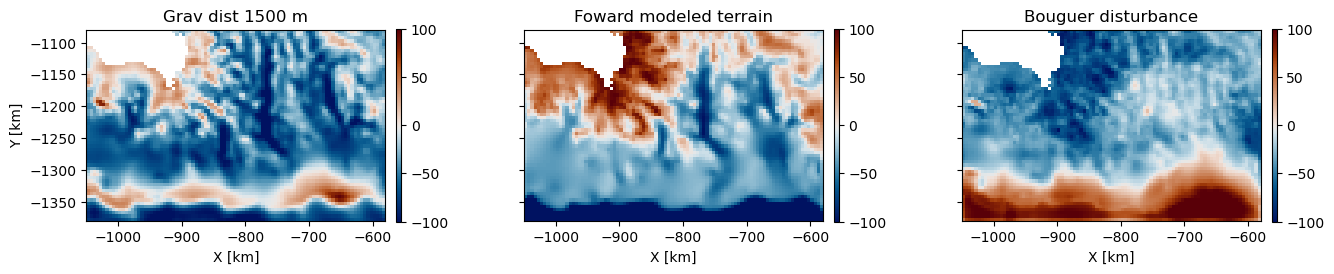

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16,2.5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, gdist_masked, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Grav dist 1500 m')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, g_z_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Foward modeled terrain')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Bouguer disturbance')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

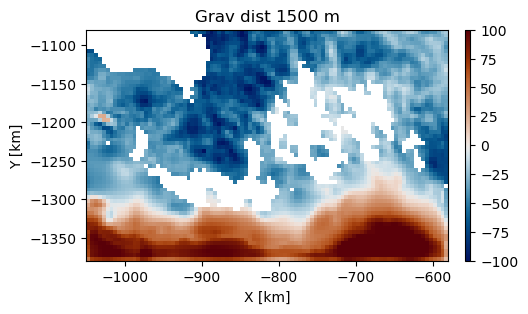

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7,3), sharey=True)
im = ax.pcolormesh(ds.x/1000, ds.y/1000, np.where(ds.mask==3, np.nan, boug_grid), cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Grav dist 1500 m')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [13]:
boug_dist = boug_grid[grav_mask]

trend = rbf_trend(ds, grav, boug_dist, smoothing=1e10, full_grid=True)
trend.shape

(60, 94)

In [14]:
residual_grid = boug_grid-trend

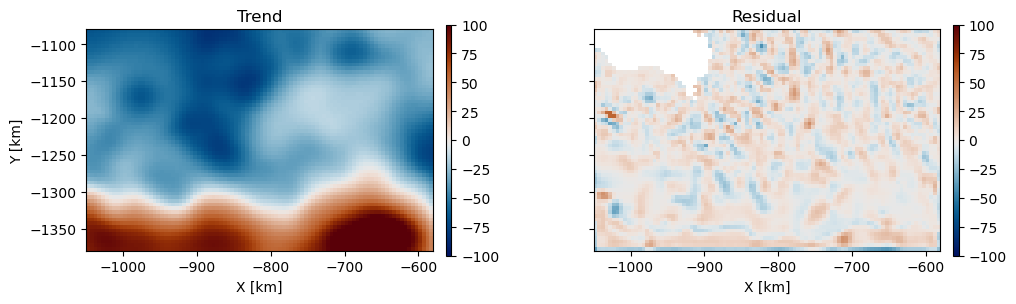

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,3), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Trend')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, residual_grid, cmap=cm.vik, vmin=-100, vmax=100)
ax.axis('scaled')
ax.set_title('Residual')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

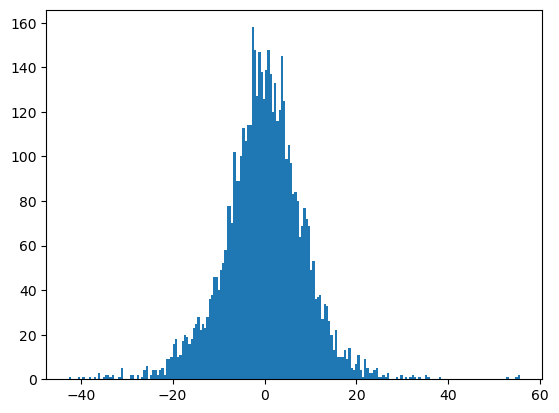

In [16]:
plt.hist(residual_grid.flatten(), bins=200)
plt.show()

In [17]:
grav.shape

(5295, 6)

In [18]:
residual = residual_grid[grav_mask]
residual.shape

(5295,)

In [19]:
trim_mask = (np.abs(residual)<25) & (grav.inv_msk==False)
residual_cond = residual[trim_mask==True]
grav_cond = grav.loc[trim_mask==True, :]

x_cond = grav_cond.x.values
y_cond = grav_cond.y.values

residual_cond.shape, grav_cond.shape

((4461,), (4461, 6))

In [20]:
trim_mask.shape

(5295,)

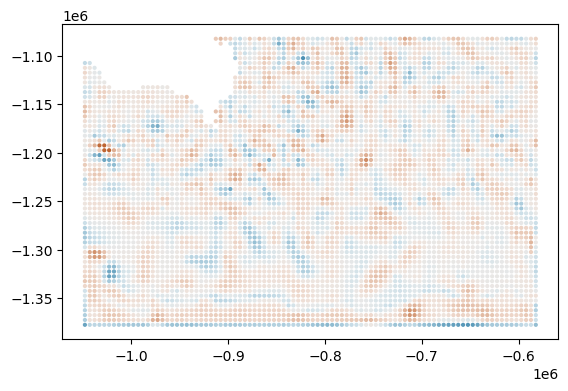

In [21]:
plt.scatter(grav.x, grav.y, c=residual, s=4, vmin=-100, vmax=100, cmap=cm.vik)
plt.axis('scaled')
plt.show()

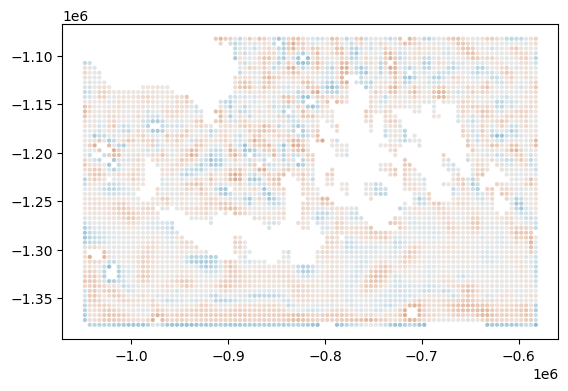

In [22]:
plt.scatter(x_cond, y_cond, c=residual_cond, s=4, vmin=-100, vmax=100, cmap=cm.vik)
plt.axis('scaled')
plt.show()

In [23]:
vgrams, df_grid, experimental, bins, nst_trans = variograms(grav_cond, residual_cond, n_lags=50, maxlag=50e3, covmodels=['gaussian', 'spherical', 'exponential', 'matern'])

In [24]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

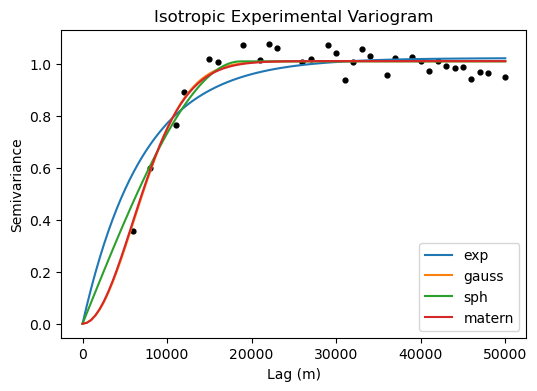

In [25]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [26]:
pred_grid = np.array([xx.flatten(), yy.flatten()]).T

# random number generator
rng = np.random.default_rng(seed=0)

parameters = vgrams['matern']

# set variogram parameters
azimuth = 0
nugget = parameters[-1]

# the major and minor ranges are the same in this example because it is isotropic
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
vtype = 'matern'

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, vtype, smoothness]

k = 50         # number of neighboring data points used to estimate a given point 
rad = 500_000    # 50 km search radius

sim1 = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)

100%|██████████| 5640/5640 [00:12<00:00, 464.68it/s]


In [27]:
sim2 = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)

100%|██████████| 5640/5640 [00:12<00:00, 466.80it/s]


In [28]:
sim3 = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)

100%|██████████| 5640/5640 [00:12<00:00, 452.60it/s]


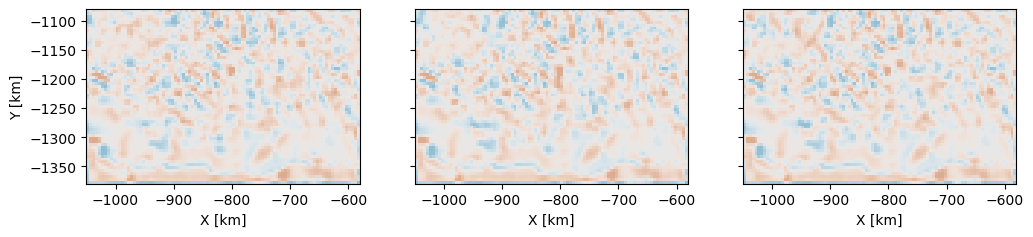

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12,5), sharey=True)

sims = [sim1, sim2, sim3]
for sim, ax in zip(sims, axs):
    sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1))
    ax.pcolormesh(ds.x/1000, ds.y/1000, sim_trans.reshape(xx.shape), cmap=cm.vik, vmin=-100, vmax=100)
    ax.axis('scaled')

axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')

plt.show()

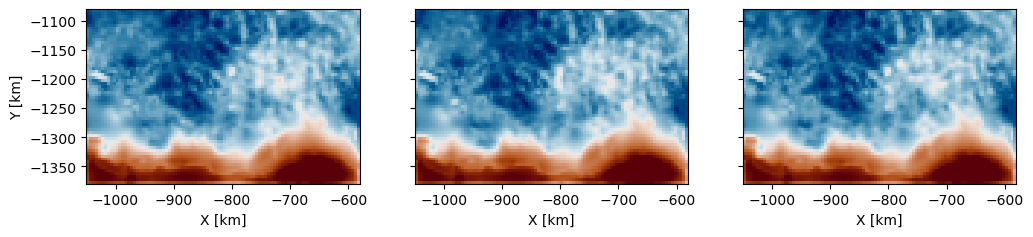

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12,5), sharey=True)

sims = [sim1, sim2, sim3]
for sim, ax in zip(sims, axs):
    sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1))
    ax.pcolormesh(ds.x/1000, ds.y/1000, sim_trans.reshape(xx.shape)+trend, cmap=cm.vik, vmin=-100, vmax=100)
    ax.axis('scaled')

axs[0].set_ylabel('Y [km]')
axs[0].set_xlabel('X [km]')
axs[1].set_xlabel('X [km]')
axs[2].set_xlabel('X [km]')

plt.show()

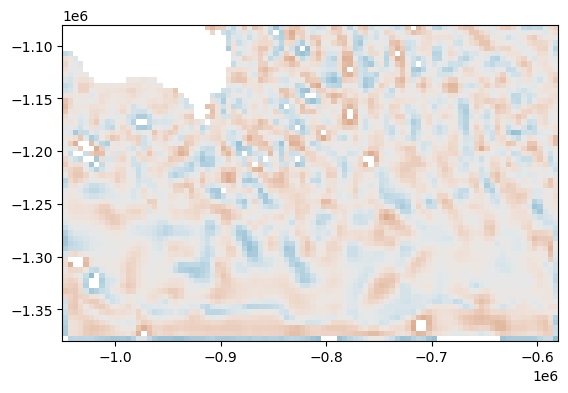

In [31]:
plt.pcolormesh(ds.x, ds.y, np.where(np.abs(residual_grid)<25, residual_grid, np.nan), cmap=cm.vik, vmin=-100, vmax=100)
plt.axis('scaled')
plt.show()

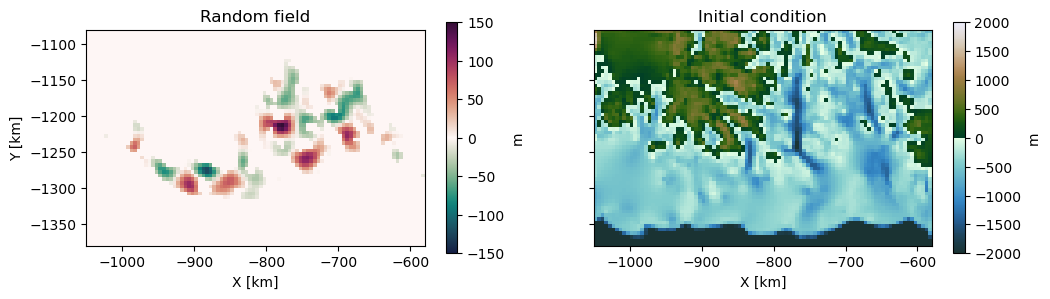

In [32]:
xkm = xx/1000
ykm = yy/1000

# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian', const_var=True, rng=rng)
field = rfgen.generate_field(condition=True)

x0 = ds.bed.values + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

vmax = np.max(np.abs(field))

fig, axs = plt.subplots(1, 2, figsize=(12,3), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m')

topo_cm = get_topo_cm()

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2000, vmin=-2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m')

plt.show()

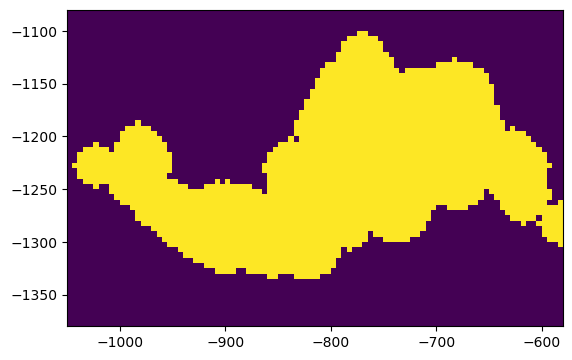

In [33]:
inv_pad = vd.distance_mask((xx[ds.inv_msk.values==True], yy[ds.inv_msk.values]), 20e3, (xx, yy))

plt.pcolormesh(xkm, ykm, inv_pad)
plt.axis('scaled')
plt.show()

In [34]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}

grav_mskd = grav[grav.inv_pad==True]
pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

pred_coords[0].shape

(2082,)

# Resimulate parts of Bouguer

In [35]:
boug_sim = sim_trans.reshape(xx.shape)

In [38]:
final_boug = boug_resample(ds, grav, df_grid, boug_sim, trend, k, vario, rad, rng, density_dict, max_iter_no_change=100, verbose=True)

1: 50 bad grid cells. 50 tried.
2: 47 bad grid cells. 47 tried.
3: 45 bad grid cells. 45 tried.
4: 38 bad grid cells. 38 tried.
5: 36 bad grid cells. 36 tried.
6: 36 bad grid cells. 36 tried.
7: 36 bad grid cells. 36 tried.
8: 36 bad grid cells. 37 tried.
9: 36 bad grid cells. 36 tried.
10: 36 bad grid cells. 42 tried.
11: 34 bad grid cells. 34 tried.
12: 34 bad grid cells. 34 tried.
13: 34 bad grid cells. 36 tried.
14: 33 bad grid cells. 33 tried.
15: 33 bad grid cells. 34 tried.
16: 33 bad grid cells. 34 tried.
17: 33 bad grid cells. 37 tried.
18: 33 bad grid cells. 34 tried.
19: 33 bad grid cells. 33 tried.
20: 33 bad grid cells. 33 tried.
21: 33 bad grid cells. 33 tried.
22: 33 bad grid cells. 34 tried.
23: 29 bad grid cells. 29 tried.
24: 29 bad grid cells. 32 tried.
25: 29 bad grid cells. 31 tried.
26: 29 bad grid cells. 31 tried.
27: 29 bad grid cells. 34 tried.
28: 29 bad grid cells. 31 tried.
29: 29 bad grid cells. 30 tried.
30: 29 bad grid cells. 29 tried.
31: 29 bad grid cel

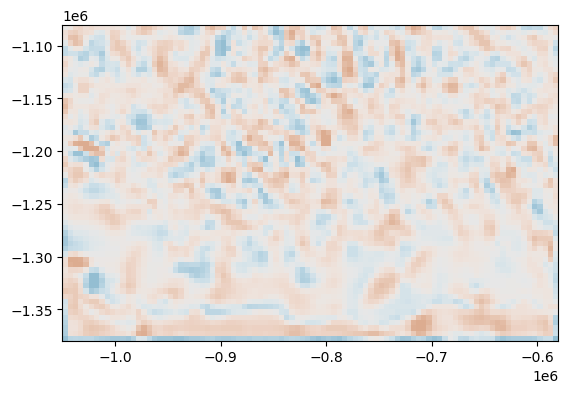

In [39]:
plt.pcolormesh(xx, yy, final_boug, cmap=cm.vik, vmin=-100, vmax=100)
plt.axis('scaled')
plt.show()

In [40]:
# boug_sim = np.where(np.abs(residual_grid)<25, sim_trans.reshape(xx.shape), residual_grid) + trend
#boug_sim = sim_trans.reshape(xx.shape) + trend
target = grav.faa - (final_boug + trend)[grav_mask]
target = target[grav.inv_pad==True]

grav_mskd = grav[grav.inv_pad==True]

target.shape, grav_mskd.shape

((2082,), (2082, 6))

In [41]:
# boug_sim = np.where(np.abs(residual_grid)<25, sim_trans.reshape(xx.shape), residual_grid) + trend
# boug_sim = sim_trans.reshape(xx.shape) + trend
# target = grav.faa - boug_sim[grav_mask]
# target = target[grav.inv_pad==True]

# grav_mskd = grav[grav.inv_pad==True]

# target.shape, grav_mskd.shape

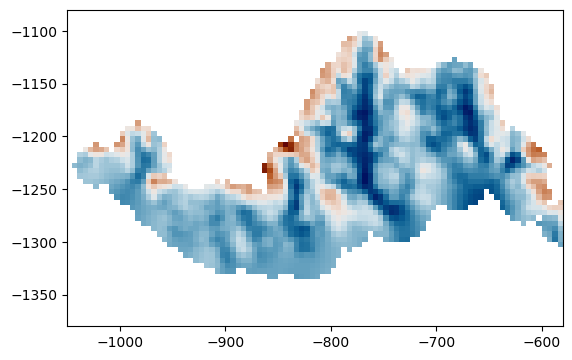

In [42]:
target_grid = xy_into_grid(ds, (grav_mskd.x.values, grav_mskd.y.values), target)

plt.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap=cm.vik)
plt.axis('scaled')
plt.show()

In [43]:
# block size, range, amplitude, iterations
sequence = [
    [21, 10, 60, 1000],
    [15, 8, 40, 1000],
    [9, 6, 40, 5000],
    [5, 5, 40, 10000]
]

# sequence = [
#     [21, 10, 100, 2000],
#     [15, 8, 80, 2000],
#     [11, 6, 60, 5000],
#     [9, 6, 60, 5000]
# ]

# gravity uncertainty
sigma = 1.6

# RMSE stopping condition
stop = 2

# run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, density_dict, rng, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.098 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.038 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.029 RMSE/sec


  0%|          | 0/10000 [00:00<?, ?it/s]

chain 3 efficiency: 0.000 RMSE/sec
0 finished
total time: 49.8


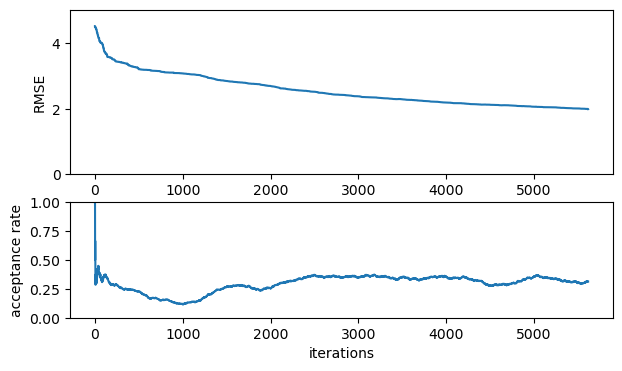

In [44]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylim(0, np.max(rmse)+0.5)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

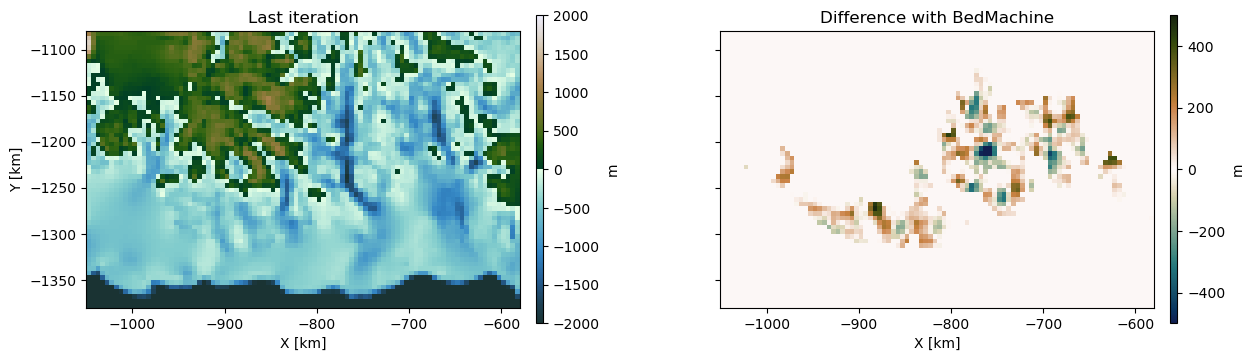

In [45]:
bed = result['bed_cache']

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(cm.bukavu, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(15,4), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

In [46]:
target_grid, grav_result_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), 
                                             (target, result['grav_cache']))

residual_grid = target_grid - grav_result_grid

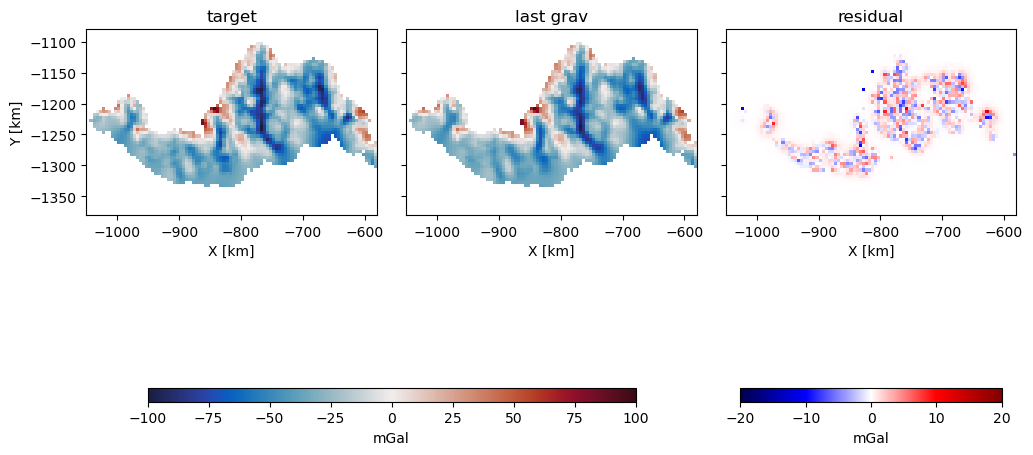

In [47]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,6.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.03], wspace=0.1)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('last grav')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, residual_grid, vmin=-20, vmax=20, cmap='seismic')
ax.axis('scaled')
ax.set_title('residual')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

In [48]:
bed_filt = lowpass_filter_invpad(ds, bed, cutoff=5e3)
bed_filt = bed_filt.reshape(bed.shape)
bed_high = bed-bed_filt

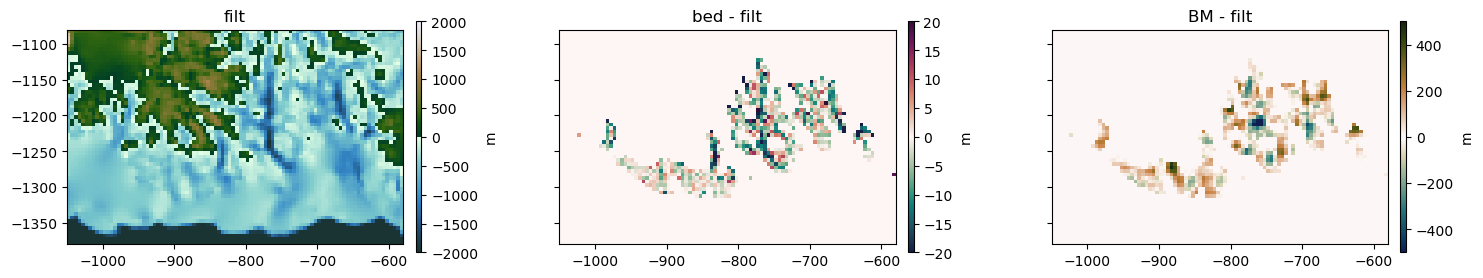

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(18,3), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
ax.set_title('filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed-bed_filt, vmin=-20, vmax=20, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('bed - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')
plt.show()

In [50]:
prisms, densities = make_prisms(ds, bed_filt, density_dict)
g_z = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')

In [51]:
np.sqrt(np.mean(np.square(target-g_z)))

np.float64(2.0023587152068534)

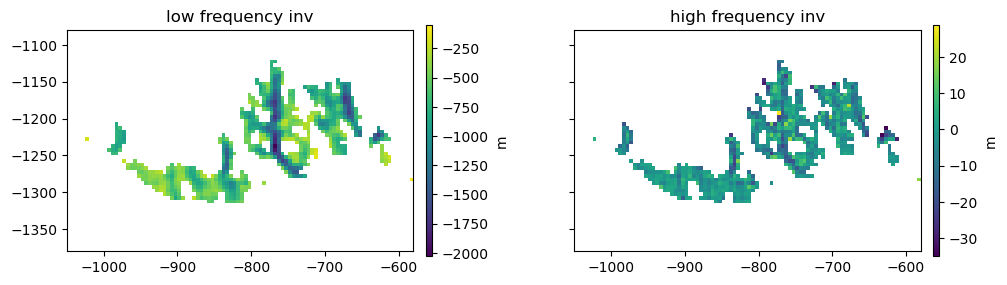

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12,3), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_filt, np.nan))
ax.axis('scaled')
ax.set_title('low frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_high, np.nan))
ax.axis('scaled')
ax.set_title('high frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

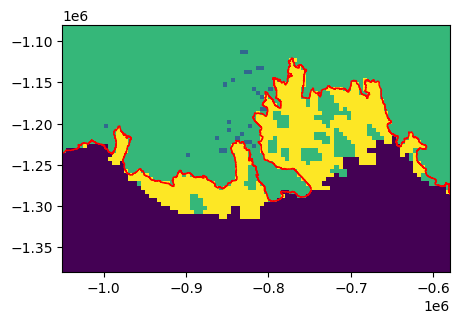

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(5,7))
ax.pcolormesh(ds.x, ds.y, ds.mask)
ax.axis('scaled')
moa_gl.plot(ax=ax, facecolor='none', edgecolor='r')
plt.show()

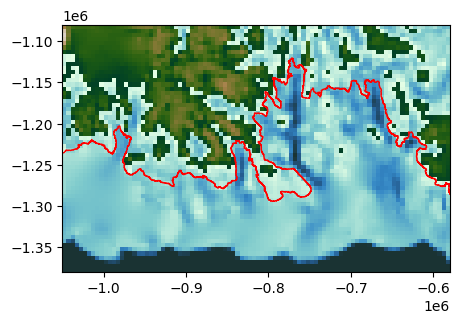

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(5,7))
ax.pcolormesh(ds.x, ds.y, bed_filt, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
moa_gl.plot(ax=ax, facecolor='none', edgecolor='r')
plt.show()

In [55]:
results_path = Path('results/salzberger')

if os.path.exists(results_path) == False:
    os.makedirs(results_path)

In [56]:
filt = False

# make base PRNG
root_seed = 328613813390984468677358742156199349641
base_seq = SeedSequence()
rng = np.random.default_rng(base_seq)

n_invs = 100

target_cache_nodens = np.zeros((n_invs, grav.shape[0]))

print(f'running {n_invs} inversions with fixed densities')
pbar = tqdm(range(n_invs))
for i in pbar:
    rng_i = np.random.default_rng([i, root_seed])

    # bouguer interpolation
    sim = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=True, seed=rng)
    sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1))
    boug_sim = sim_trans.reshape(xx.shape)
    final_boug = boug_resample(ds, grav, df_grid, boug_sim, trend, k, vario, rad, rng_i, density_dict, max_iter_no_change=100, verbose=False)
    target = grav.faa - (final_boug + trend)[grav_mask]

    # if filt == True:
    #     boug_filt = filter_boug(ds, grav, target, cutoff=12e3, pad=0)
    #     target = grav.faa.values - boug_filt

    # save target
    target_cache_nodens[i,:] = target
    
    # trim to mask
    target = target[grav.inv_pad==True]

    # initial pertubation away from BedMachine
    rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian', rng=rng_i)
    x0 = ds.bed.data + rfgen.generate_field(condition=True, seed=rng_i.integers(10_000, 20_000, 1))
    x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)
    
    path = Path(results_path/f'result_{i}.npy')
    
    result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, density_dict, rng_i, 
                            weights=None, stop=stop, save=path, full_cache=False, quiet=True, num_mp = i+1)

    pbar.update(1)
pbar.close()

np.save(results_path/'bouguer_cache.npy', target_cache_nodens)

running 100 inversions with fixed densities


  0%|          | 0/100 [00:00<?, ?it/s]

max iterations with no change reached after 525 iterations
5 bad grid cells remaining were hard-corrected
1 finished
max iterations with no change reached after 321 iterations
5 bad grid cells remaining were hard-corrected
2 finished
max iterations with no change reached after 361 iterations
6 bad grid cells remaining were hard-corrected
3 finished
max iterations with no change reached after 407 iterations
6 bad grid cells remaining were hard-corrected
4 finished
max iterations with no change reached after 620 iterations
5 bad grid cells remaining were hard-corrected
5 finished
max iterations with no change reached after 274 iterations
7 bad grid cells remaining were hard-corrected
6 finished
max iterations with no change reached after 382 iterations
6 bad grid cells remaining were hard-corrected
7 finished
max iterations with no change reached after 298 iterations
5 bad grid cells remaining were hard-corrected
8 finished
max iterations with no change reached after 538 iterations
5 bad

In [57]:
grid = xr.open_dataset(Path('G:/stochastic_bathymetry/raw_data/bedmachine/BedMachineAntarctica-v3.nc'))

xx, yy = np.meshgrid(ds.x, ds.y)

# trim original BedMachine, get coordinates
x_trim = (grid.x >= np.min(xx)) & (grid.x <= np.max(xx))
y_trim = (grid.y >= np.min(yy)) & (grid.y <= np.max(yy))
grid = grid.sel(x=x_trim, y=y_trim)
xx_bm, yy_bm = np.meshgrid(grid.x.values, grid.y.values)

# interpolate inversion mask to original resolution
kn = vd.KNeighbors(1)
kn.fit((xx.flatten(), yy.flatten()), ds.inv_msk.values.flatten())
preds_msk = kn.predict((xx_bm, yy_bm))
preds_msk = preds_msk.reshape(xx_bm.shape) > 0.5

# save ensemble with conditioning and density
print('upscaling beds cd')
save_upscale(ds, grid, preds_msk,
             results_path,
             results_path/'ensemble_geoid_2000.nc',
             results_path/'ensemble_geoid_500.nc')

upscaling beds cd
 100 inversions


  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
ensemble = xr.load_dataarray(results_path/'ensemble_geoid_2000.nc')

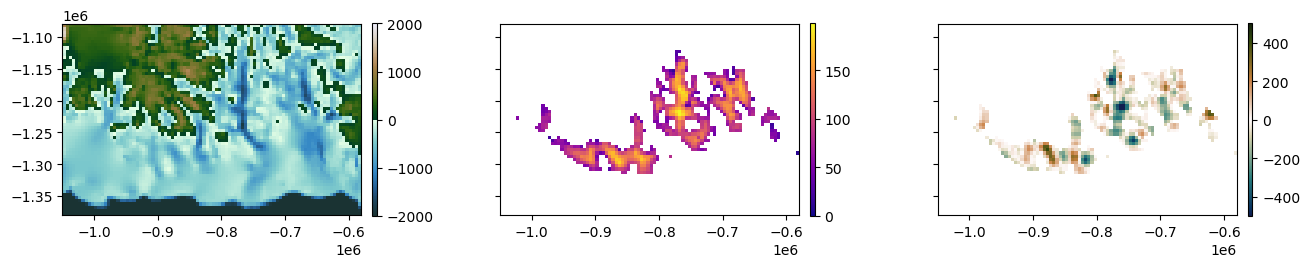

In [72]:
ensemble_mean = np.mean(ensemble.values, axis=0)
ensemble_std = np.std(ensemble.values, axis=0)
ensemble_diff = ds.bed-np.mean(ensemble.values, axis=0)

fig, axs = plt.subplots(1, 3, figsize=(16,2.5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ensemble.x, ensemble.y, ensemble_mean, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ensemble.x, ensemble.y, np.where(ds.inv_msk, ensemble_std, np.nan), vmin=0, cmap='plasma')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ensemble.x, ensemble.y, np.where(ds.inv_msk, ensemble_diff, np.nan), vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

In [73]:
ensemble = xr.load_dataarray(results_path/'ensemble_geoid_500.nc')

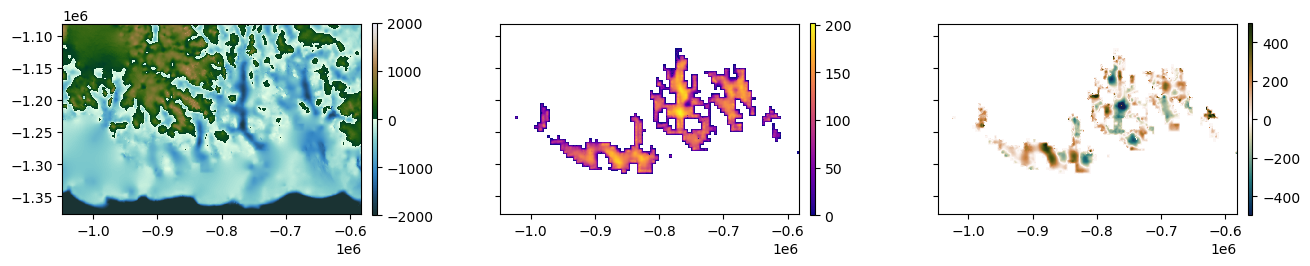

In [74]:
ensemble_mean = np.mean(ensemble.values, axis=0)
ensemble_std = np.std(ensemble.values, axis=0)
ensemble_diff = grid.bed-np.mean(ensemble.values, axis=0)

fig, axs = plt.subplots(1, 3, figsize=(16,2.5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ensemble.x, ensemble.y, ensemble_mean, vmin=-2000, vmax=2000, cmap=cm.bukavu)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(ensemble.x, ensemble.y, np.where(preds_msk, ensemble_std, np.nan), vmin=0, cmap='plasma')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(ensemble.x, ensemble.y, np.where(preds_msk, ensemble_diff, np.nan), vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

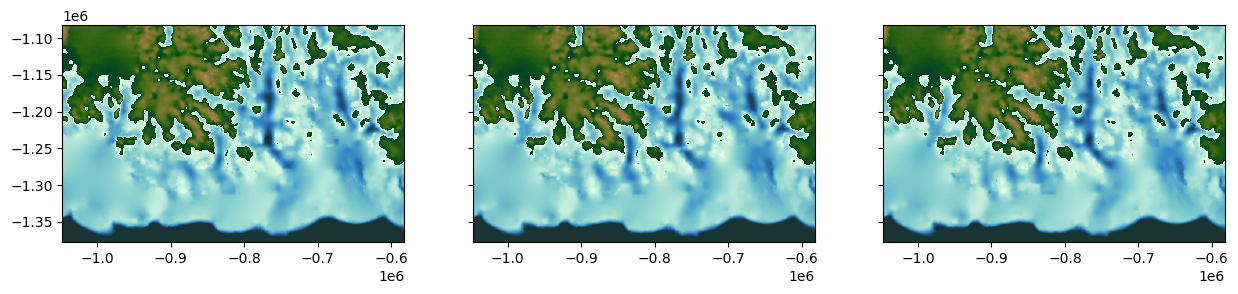

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, ax in enumerate(axs):
    ax.pcolormesh(ensemble.x, ensemble.y, ensemble.sel(i=i), vmin=-2000, vmax=2000, cmap=cm.bukavu)
    ax.axis('scaled')
plt.show()